In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
from utils.metrics import rel_err, rank_corr, mse_K
from nphc3.optim import gradient_f, gradient_f_ijk
from numba import autojit

## Load data

### Exponential kernel, 2 non symmetric blocks, ratio of $50$ between the $\beta$, $d=10$

In [2]:
url = 'https://s3-eu-west-1.amazonaws.com/nphc-data/d10_2blocks_nonsym_with_Beta_without_N.pkl.gz'
from utils.loader import load_data
cumul,Beta = load_data(url)

... loading data


## Uses `adagrad` to minimize objective

In [3]:
d = cumul.dim
eta = 1e2
lbd_l1 = 0
lbd_nuc = 0
n_iter = 300000

In [4]:
from utils.prox import *
from nphc3.optim import inspector, nag, adagrad
objective = lambda R: mse_K(cumul,R)

## Solution to single instance

In [5]:
#R0_ = np.arange(d**2).reshape(d,d)/(d**2)
R0_ = np.ones((d,d))

adagrad_inspector = inspector(objective,cumul.R_true,n_iter=n_iter)
def grad_fun_ijk(R,i,j,k):
    return gradient_f_ijk(cumul,R,i,j,k)
#R_adagrad = adagrad(R0_,grad_fun_ijk,n_iter=n_iter,step=eta,prox=prox_nuclear,lbd=lbd_nuc,callback=adagrad_inspector)
R_adagrad = adagrad(R0_,grad_fun_ijk,n_iter=n_iter,step=eta,prox=prox_l1,lbd=lbd_l1,callback=adagrad_inspector)
#R_adagrad = adagrad(R0_,grad_fun_ijk,n_iter=n_iter,step=eta,prox=prox_zero,lbd=lbd_l1,callback=adagrad_inspector)

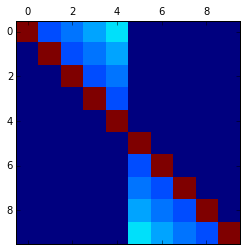

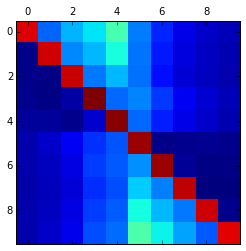

In [6]:
plt.matshow(cumul.R_true)
plt.matshow(R_adagrad)

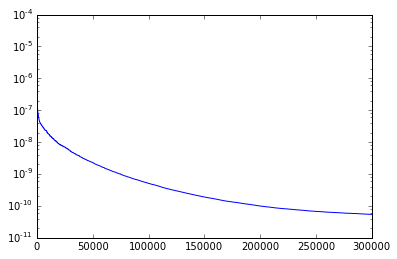

In [7]:
plt.plot(adagrad_inspector.obj)
plt.yscale('log')

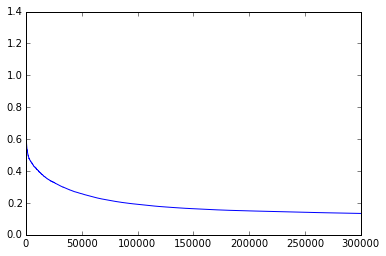

In [8]:
plt.plot(adagrad_inspector.err)

## Solution to multiple, random instances

In [9]:
d = cumul.dim
eta = 1e2
lbd_l1 = 0
lbd_nuc = 0
n_iter = 200000
n_start = 100

In [10]:
inspectors = [ inspector(objective,cumul.R_true,n_iter=n_iter) for i in range(n_start)]
R = np.zeros((n_start,d,d))

In [11]:
# defines gradient
def grad_fun_ijk(R,i,j,k):
    return gradient_f_ijk(cumul,R,i,j,k)
# iterates
R = np.array([adagrad(np.random.uniform(size=(d,d)),
                      grad_fun_ijk,n_iter=n_iter,
                      step=eta,prox=prox_l1,
                      lbd=lbd_l1,callback=ai)
              for i,ai in enumerate(inspectors)])

### Check for multiple solutions
Let's see how close are the solutions

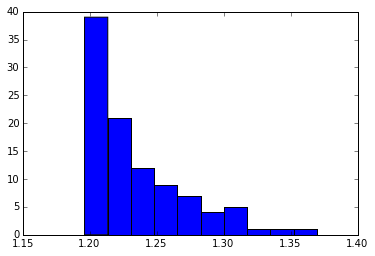

In [12]:
bins,vals,patches = plt.hist(R[:,0,0])

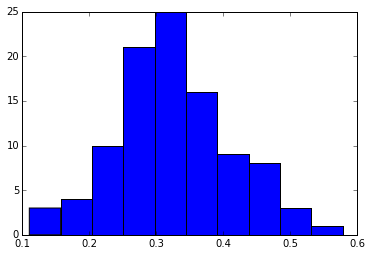

In [13]:
bins,vals,patches = plt.hist(R[:,1,2])

It seems that the histogram has a non-zero width... Ideally, we would like to understand:

* The behavior for finite sample length (this would test the uniqueness of the solution)
* The behavior when you have large data (maybe you have many solutions that become very close...)

### Objective function
Let's also check the inspector for the values of the objective

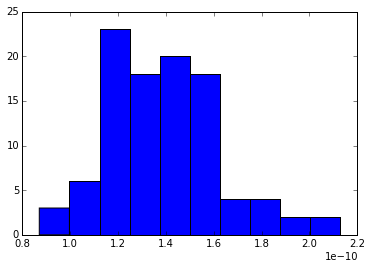

In [14]:
bins,vals,patches = plt.hist(np.array([i.obj[-1] for i in inspectors]))

Everything is around 1e-10, it doesn't seem that there are different values for the minima. At first sight, it seems that *if there are multiple minima, they are degenerate*.

This is not good news, because it seems that *we cannot distinguish very well the solutions found above on the basis of the objective function*. Let's check more precisely.

In [15]:
s_insp = sorted(inspectors,key=lambda x: x.obj[-1])
scores = np.array([i.obj[-1] for i in s_insp])
rel_err = np.array([i.err[-1] for i in s_insp])
np.corrcoef(scores,rel_err)

array([[ 1.        ,  0.38026622],
       [ 0.38026622,  1.        ]])

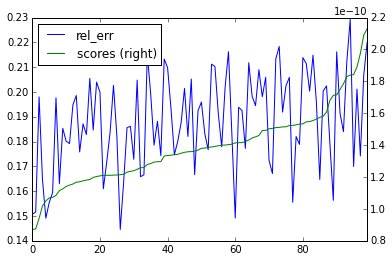

In [16]:
import pandas as pd
pd.DataFrame({'scores' : scores, 'rel_err' : rel_err}).plot(secondary_y='scores')

There doesn't seem to be such a relevant link between score and relative error, but it's probably worth checking more precisely (more data/larger sample)

### Finally, I save the outcome

In [18]:
#import pickle
#pickle.dump(R,open('/Users/iacopomastromatteo/Desktop/r.p','wb'))